In [109]:
# !pip install xgboost

In [110]:
import os
import numpy as np
import yaml
from yaml import safe_load
from tqdm import tqdm
import warnings
import pandas as pd
import math
from math import floor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor, callback
from sklearn.metrics import r2_score , mean_squared_error , mean_absolute_error, max_error
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [111]:
directory_path = r'D:\new_workspace\CEP\odis'   #change this path accordingly
data_list = []

for filename in os.listdir(directory_path):
    path = os.path.join(directory_path , filename)
    if not filename.endswith('.txt'):
        data_list.append(path)


In [112]:
data_set = pd.DataFrame()
counter = 1
for i in tqdm(data_list):
    with open(i , 'r') as f:
        data = yaml.safe_load(f)
        if isinstance(data , list) or isinstance(data , dict):
            data_frame = pd.json_normalize(data)
        else:
            raise ValueError(f'There was an issue with the File {i}')
        
        data_frame['match_id'] = counter
        data_set = pd.concat([data_set , data_frame], ignore_index = True)
        counter+=1


100%|██████████| 2858/2858 [21:18<00:00,  2.23it/s]


In [113]:
data_set.head()

,innings,meta.data_version,meta.created,meta.revision,info.balls_per_over,info.city,info.dates,info.gender,info.match_type,info.outcome.by.runs,...,info.registry.people.Waleed Yaqub,info.registry.people.RN Hendricks,info.registry.people.SP Terry,info.registry.people.DJ Worrall,info.registry.people.CP Tremain,info.registry.people.JM Mennie,info.registry.people.DS Weerakkody,info.registry.people.IG Warne,info.registry.people.CC Dalton,info.registry.people.S Wijesundera
0,"[{'1st innings': {'team': 'Australia', 'delive...",0.91,2017-01-14,2,6,Brisbane,[2017-01-13],male,ODI,92.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"[{'1st innings': {'team': 'Australia', 'delive...",0.91,2017-01-18,1,6,NaN,[2017-01-15],male,ODI,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"[{'1st innings': {'team': 'Pakistan', 'deliver...",0.91,2017-01-21,1,6,Perth,[2017-01-19],male,ODI,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"[{'1st innings': {'team': 'Australia', 'delive...",0.91,2017-01-22,1,6,NaN,[2017-01-22],male,ODI,86.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"[{'1st innings': {'team': 'Australia', 'delive...",0.91,2017-01-28,1,6,NaN,[2017-01-26],male,ODI,57.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [114]:
# files_name = []
# dir_path = r'D:\new_workspace\CEP\odis'

# for file in os.listdir(dir_path):
#     # Get the full file path
#     full_path = os.path.join(dir_path, file)
#     # Check if the file is not a .txt file since there is one README.txt in the folder
#     if not file.endswith('.txt'):
#         # Add the file path to the list
#         files_name.append(full_path)

# final_df=pd.DataFrame()
# counter=1
# for i in tqdm(files_name):
#     with open(i,'r') as f:
#         data = yaml.safe_load(f)
#         if isinstance(data, list) or isinstance(data, dict):
#             df = pd.json_normalize(data)
#         else:
#             raise ValueError(f"File {i} does not contain a list or dict")
#         df['match_id']=counter
#         final_df=pd.concat([final_df,df],ignore_index=True)
#         counter+=1
# final_df

In [115]:
#create a backup in case of error

backup_data = data_set.copy()

In [116]:
columns = [
    
    'innings',
    'info.city',
    'info.dates',
    'info.gender',
    'info.match_type',
    'info.outcome.winner',
    'info.overs',
    'info.player_of_match',
    'info.teams',
    'info.toss.decision',
    'info.toss.winner',
    'info.umpires',
    'info.venue',
    'match_id'

]

data_set = data_set[columns]

data_set.head()

,innings,info.city,info.dates,info.gender,info.match_type,info.outcome.winner,info.overs,info.player_of_match,info.teams,info.toss.decision,info.toss.winner,info.umpires,info.venue,match_id
0,"[{'1st innings': {'team': 'Australia', 'delive...",Brisbane,[2017-01-13],male,ODI,Australia,50,[MS Wade],"[Australia, Pakistan]",bat,Australia,"[MD Martell, C Shamshuddin]","Brisbane Cricket Ground, Woolloongabba",1
1,"[{'1st innings': {'team': 'Australia', 'delive...",NaN,[2017-01-15],male,ODI,Pakistan,50,[Mohammad Hafeez],"[Australia, Pakistan]",bat,Australia,"[CB Gaffaney, P Wilson]",Melbourne Cricket Ground,2
2,"[{'1st innings': {'team': 'Pakistan', 'deliver...",Perth,[2017-01-19],male,ODI,Australia,50,[SPD Smith],"[Australia, Pakistan]",field,Australia,"[SD Fry, C Shamshuddin]",Western Australia Cricket Association Ground,3
3,"[{'1st innings': {'team': 'Australia', 'delive...",NaN,[2017-01-22],male,ODI,Australia,50,[DA Warner],"[Australia, Pakistan]",bat,Australia,"[CB Gaffaney, MD Martell]",Sydney Cricket Ground,4
4,"[{'1st innings': {'team': 'Australia', 'delive...",NaN,[2017-01-26],male,ODI,Australia,50,[DA Warner],"[Australia, Pakistan]",bat,Australia,"[SD Fry, C Shamshuddin]",Adelaide Oval,5


In [117]:
data_set.shape

(2858, 14)

In [118]:
# data_set['info.gender'].value_counts()

# data_set = data_set[data_set['info.gender'] == 'male']        #set inplace to False before uncommenting and re-executing the code
# data_set.drop(columns=['info.gender'] , inplace=True)
data_set



,innings,info.city,info.dates,info.gender,info.match_type,info.outcome.winner,info.overs,info.player_of_match,info.teams,info.toss.decision,info.toss.winner,info.umpires,info.venue,match_id
0,"[{'1st innings': {'team': 'Australia', 'delive...",Brisbane,[2017-01-13],male,ODI,Australia,50,[MS Wade],"[Australia, Pakistan]",bat,Australia,"[MD Martell, C Shamshuddin]","Brisbane Cricket Ground, Woolloongabba",1
1,"[{'1st innings': {'team': 'Australia', 'delive...",NaN,[2017-01-15],male,ODI,Pakistan,50,[Mohammad Hafeez],"[Australia, Pakistan]",bat,Australia,"[CB Gaffaney, P Wilson]",Melbourne Cricket Ground,2
2,"[{'1st innings': {'team': 'Pakistan', 'deliver...",Perth,[2017-01-19],male,ODI,Australia,50,[SPD Smith],"[Australia, Pakistan]",field,Australia,"[SD Fry, C Shamshuddin]",Western Australia Cricket Association Ground,3
3,"[{'1st innings': {'team': 'Australia', 'delive...",NaN,[2017-01-22],male,ODI,Australia,50,[DA Warner],"[Australia, Pakistan]",bat,Australia,"[CB Gaffaney, MD Martell]",Sydney Cricket Ground,4
4,"[{'1st innings': {'team': 'Australia', 'delive...",NaN,[2017-01-26],male,ODI,Australia,50,[DA Warner],"[Australia, Pakistan]",bat,Australia,"[SD Fry, C Shamshuddin]",Adelaide Oval,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2853,"[{'1st innings': {'team': 'Sri Lanka', 'delive...",NaN,[2016-08-28],male,ODI,Australia,50,[GJ Bailey],"[Sri Lanka, Australia]",bat,Sri Lanka,"[Aleem Dar, REJ Martinesz]",Rangiri Dambulla International Stadium,2854
2854,"[{'1st innings': {'team': 'Sri Lanka', 'delive...",NaN,[2016-08-31],male,ODI,Australia,50,[JW Hastings],"[Sri Lanka, Australia]",bat,Sri Lanka,"[MA Gough, RSA Palliyaguruge]",Rangiri Dambulla International Stadium,2855
2855,"[{'1st innings': {'team': 'Sri Lanka', 'delive...",NaN,[2016-09-04],male,ODI,Australia,50,[DA Warner],"[Sri Lanka, Australia]",bat,Sri Lanka,"[Aleem Dar, RSA Palliyaguruge]",Pallekele International Cricket Stadium,2856
2856,"[{'1st innings': {'team': 'Scotland', 'deliver...",Edinburgh,[2016-08-14],male,ODI,Scotland,50,NaN,"[Scotland, United Arab Emirates]",field,United Arab Emirates,"[DA Haggo, M Hawthorne]","Grange Cricket Club Ground, Raeburn Place",2857


In [119]:
data_set.shape

(2858, 14)

In [120]:
# x = data_set['info.match_type'].value_counts();y = data_set['info.overs'].value_counts()
# print(x)
# print(y)

In [121]:

data_set

,innings,info.city,info.dates,info.gender,info.match_type,info.outcome.winner,info.overs,info.player_of_match,info.teams,info.toss.decision,info.toss.winner,info.umpires,info.venue,match_id
0,"[{'1st innings': {'team': 'Australia', 'delive...",Brisbane,[2017-01-13],male,ODI,Australia,50,[MS Wade],"[Australia, Pakistan]",bat,Australia,"[MD Martell, C Shamshuddin]","Brisbane Cricket Ground, Woolloongabba",1
1,"[{'1st innings': {'team': 'Australia', 'delive...",NaN,[2017-01-15],male,ODI,Pakistan,50,[Mohammad Hafeez],"[Australia, Pakistan]",bat,Australia,"[CB Gaffaney, P Wilson]",Melbourne Cricket Ground,2
2,"[{'1st innings': {'team': 'Pakistan', 'deliver...",Perth,[2017-01-19],male,ODI,Australia,50,[SPD Smith],"[Australia, Pakistan]",field,Australia,"[SD Fry, C Shamshuddin]",Western Australia Cricket Association Ground,3
3,"[{'1st innings': {'team': 'Australia', 'delive...",NaN,[2017-01-22],male,ODI,Australia,50,[DA Warner],"[Australia, Pakistan]",bat,Australia,"[CB Gaffaney, MD Martell]",Sydney Cricket Ground,4
4,"[{'1st innings': {'team': 'Australia', 'delive...",NaN,[2017-01-26],male,ODI,Australia,50,[DA Warner],"[Australia, Pakistan]",bat,Australia,"[SD Fry, C Shamshuddin]",Adelaide Oval,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2853,"[{'1st innings': {'team': 'Sri Lanka', 'delive...",NaN,[2016-08-28],male,ODI,Australia,50,[GJ Bailey],"[Sri Lanka, Australia]",bat,Sri Lanka,"[Aleem Dar, REJ Martinesz]",Rangiri Dambulla International Stadium,2854
2854,"[{'1st innings': {'team': 'Sri Lanka', 'delive...",NaN,[2016-08-31],male,ODI,Australia,50,[JW Hastings],"[Sri Lanka, Australia]",bat,Sri Lanka,"[MA Gough, RSA Palliyaguruge]",Rangiri Dambulla International Stadium,2855
2855,"[{'1st innings': {'team': 'Sri Lanka', 'delive...",NaN,[2016-09-04],male,ODI,Australia,50,[DA Warner],"[Sri Lanka, Australia]",bat,Sri Lanka,"[Aleem Dar, RSA Palliyaguruge]",Pallekele International Cricket Stadium,2856
2856,"[{'1st innings': {'team': 'Scotland', 'deliver...",Edinburgh,[2016-08-14],male,ODI,Scotland,50,NaN,"[Scotland, United Arab Emirates]",field,United Arab Emirates,"[DA Haggo, M Hawthorne]","Grange Cricket Club Ground, Raeburn Place",2857


In [122]:
data_set.iloc[0]['innings'][0]['1st innings']['deliveries']

[{0.1: {'batsman': 'DA Warner',
   'bowler': 'Mohammad Amir',
   'non_striker': 'TM Head',
   'runs': {'batsman': 0, 'extras': 0, 'total': 0}}},
 {0.2: {'batsman': 'DA Warner',
   'bowler': 'Mohammad Amir',
   'non_striker': 'TM Head',
   'runs': {'batsman': 0, 'extras': 0, 'total': 0}}},
 {0.3: {'batsman': 'DA Warner',
   'bowler': 'Mohammad Amir',
   'non_striker': 'TM Head',
   'runs': {'batsman': 0, 'extras': 0, 'total': 0}}},
 {0.4: {'batsman': 'DA Warner',
   'bowler': 'Mohammad Amir',
   'non_striker': 'TM Head',
   'runs': {'batsman': 0, 'extras': 0, 'total': 0}}},
 {0.5: {'batsman': 'DA Warner',
   'bowler': 'Mohammad Amir',
   'extras': {'wides': 1},
   'non_striker': 'TM Head',
   'runs': {'batsman': 0, 'extras': 1, 'total': 1}}},
 {0.6: {'batsman': 'DA Warner',
   'bowler': 'Mohammad Amir',
   'non_striker': 'TM Head',
   'runs': {'batsman': 0, 'extras': 0, 'total': 0}}},
 {0.7: {'batsman': 'DA Warner',
   'bowler': 'Mohammad Amir',
   'non_striker': 'TM Head',
   'runs': {

In [123]:
count =  1
delivery_datafr = pd.DataFrame()
for index , row in data_set.iterrows():
    if count  in [75,108,150,180,268,360,443,458,584,748,982,1052,1111,1226,1345]:
        count+=1
        continue
    count+=1
    ball_of_match = []
    batsman = []
    bowler = []
    runs = []
    player_of_dismissed = []
    teams = []
    batting_team = []
    match_id = []
    city = []
    venue = []
    for ball in row ["innings"][0]["1st innings"]["deliveries"]:
        for key in ball.keys():
            match_id.append(count)
            batting_team.append(row['innings'][0]['1st innings']['team'])
            teams.append(row['info.teams'])
            ball_of_match.append(key)
            batsman.append(ball[key]['batsman'])
            bowler.append(ball[key]['bowler'])
            runs.append(ball[key]['runs']['total'])
            city.append(row['info.city'])
            venue.append(row['info.venue'])
            try:
                player_of_dismissed.append(ball[key]['wicket']['player_out'])
            except:
                player_of_dismissed.append('0')
    loop_df = pd.DataFrame({
            'match_id':match_id,
            'teams':teams,
            'batting_team':batting_team,
            'ball':ball_of_match,
            'batsman':batsman,
            'bowler':bowler,
            'runs':runs,
            'player_dismissed':player_of_dismissed,
            'city':city,
            'venue':venue
        })
    delivery_datafr = pd.concat([delivery_datafr,loop_df])

In [124]:
dev = delivery_datafr.head(2);cts = delivery_datafr.shape
print(dev)
print(cts)

   match_id                  teams batting_team  ball    batsman  \
0         2  [Australia, Pakistan]    Australia   0.1  DA Warner   
1         2  [Australia, Pakistan]    Australia   0.2  DA Warner   

          bowler  runs player_dismissed      city  \
0  Mohammad Amir     0                0  Brisbane   
1  Mohammad Amir     0                0  Brisbane   

                                    venue  
0  Brisbane Cricket Ground, Woolloongabba  
1  Brisbane Cricket Ground, Woolloongabba  
(819414, 10)


In [125]:
def bowl(row):
    for team in row['teams']:
        if team != row['batting_team']:
            return team
        
delivery_datafr['bowling_team'] = delivery_datafr.apply(bowl , axis=1)


In [126]:
delivery_datafr

,match_id,teams,batting_team,ball,batsman,bowler,runs,player_dismissed,city,venue,bowling_team
0,2,"[Australia, Pakistan]",Australia,0.1,DA Warner,Mohammad Amir,0,0,Brisbane,"Brisbane Cricket Ground, Woolloongabba",Pakistan
1,2,"[Australia, Pakistan]",Australia,0.2,DA Warner,Mohammad Amir,0,0,Brisbane,"Brisbane Cricket Ground, Woolloongabba",Pakistan
2,2,"[Australia, Pakistan]",Australia,0.3,DA Warner,Mohammad Amir,0,0,Brisbane,"Brisbane Cricket Ground, Woolloongabba",Pakistan
3,2,"[Australia, Pakistan]",Australia,0.4,DA Warner,Mohammad Amir,0,0,Brisbane,"Brisbane Cricket Ground, Woolloongabba",Pakistan
4,2,"[Australia, Pakistan]",Australia,0.5,DA Warner,Mohammad Amir,1,0,Brisbane,"Brisbane Cricket Ground, Woolloongabba",Pakistan
...,...,...,...,...,...,...,...,...,...,...,...
281,2859,"[Scotland, United Arab Emirates]",United Arab Emirates,44.6,Ahmed Raza,CB Sole,0,0,Edinburgh,"Grange Cricket Club Ground, Raeburn Place",Scotland
282,2859,"[Scotland, United Arab Emirates]",United Arab Emirates,45.1,Fayyaz Ahmed,AC Evans,1,0,Edinburgh,"Grange Cricket Club Ground, Raeburn Place",Scotland
283,2859,"[Scotland, United Arab Emirates]",United Arab Emirates,45.2,Ahmed Raza,AC Evans,0,0,Edinburgh,"Grange Cricket Club Ground, Raeburn Place",Scotland
284,2859,"[Scotland, United Arab Emirates]",United Arab Emirates,45.3,Ahmed Raza,AC Evans,0,0,Edinburgh,"Grange Cricket Club Ground, Raeburn Place",Scotland


In [127]:
delivery_datafr['batting_team'].unique()

array(['Australia', 'Pakistan', 'Scotland', 'Zimbabwe', 'New Zealand',
       'Bangladesh', 'South Africa', 'India', 'England', 'Sri Lanka',
       'Hong Kong', 'Papua New Guinea', 'West Indies', 'Ireland',
       'United Arab Emirates', 'Nepal', 'United States of America',
       'Namibia', 'Oman', 'Netherlands', 'Thailand', 'Canada', 'Jersey',
       'Africa XI', 'Kenya', 'Bermuda', 'Asia XI'], dtype=object)

In [128]:
delivery_datafr['batting_team'].value_counts().head(5)

batting_team
Australia    92088
Sri Lanka    85636
India        83665
England      76695
Pakistan     69220
Name: count, dtype: int64

In [129]:
teams = [
    "Australia"
    ,"Pakistan",
    "England ",
    "India",
    "West Indies",
    "New Zealand",
    "Sri Lanka",
    "Bangladesh",
    "South Africa",
    "Ireland"  
]



In [130]:
delivery_datafr["bowling_team"].unique()

array(['Pakistan', 'Australia', 'New Zealand', 'Hong Kong', 'India',
       'Bangladesh', 'South Africa', 'England', 'Sri Lanka',
       'Papua New Guinea', 'West Indies', 'Ireland',
       'United Arab Emirates', 'Zimbabwe', 'Scotland', 'Nepal',
       'Netherlands', 'Oman', 'United States of America', 'Namibia',
       'Thailand', 'Canada', 'Jersey', 'Asia XI', 'ICC World XI',
       'Bermuda', 'Kenya', 'Africa XI'], dtype=object)

In [131]:
delivery_datafr["bowling_team"].value_counts().head(10)


bowling_team
India           89535
England         78488
Pakistan        73132
South Africa    71719
Australia       70616
West Indies     68462
Sri Lanka       66920
New Zealand     66426
Bangladesh      51965
Zimbabwe        43618
Name: count, dtype: int64

In [132]:
delivery_datafr = delivery_datafr[delivery_datafr["batting_team"].isin(teams)]
delivery_datafr = delivery_datafr[delivery_datafr["bowling_team"].isin(teams)]

delivery_datafr


,match_id,teams,batting_team,ball,batsman,bowler,runs,player_dismissed,city,venue,bowling_team
0,2,"[Australia, Pakistan]",Australia,0.1,DA Warner,Mohammad Amir,0,0,Brisbane,"Brisbane Cricket Ground, Woolloongabba",Pakistan
1,2,"[Australia, Pakistan]",Australia,0.2,DA Warner,Mohammad Amir,0,0,Brisbane,"Brisbane Cricket Ground, Woolloongabba",Pakistan
2,2,"[Australia, Pakistan]",Australia,0.3,DA Warner,Mohammad Amir,0,0,Brisbane,"Brisbane Cricket Ground, Woolloongabba",Pakistan
3,2,"[Australia, Pakistan]",Australia,0.4,DA Warner,Mohammad Amir,0,0,Brisbane,"Brisbane Cricket Ground, Woolloongabba",Pakistan
4,2,"[Australia, Pakistan]",Australia,0.5,DA Warner,Mohammad Amir,1,0,Brisbane,"Brisbane Cricket Ground, Woolloongabba",Pakistan
...,...,...,...,...,...,...,...,...,...,...,...
244,2857,"[Sri Lanka, Australia]",Sri Lanka,39.5,SS Pathirana,MA Starc,0,0,NaN,Pallekele International Cricket Stadium,Australia
245,2857,"[Sri Lanka, Australia]",Sri Lanka,39.6,SS Pathirana,MA Starc,0,0,NaN,Pallekele International Cricket Stadium,Australia
246,2857,"[Sri Lanka, Australia]",Sri Lanka,39.7,SS Pathirana,MA Starc,1,0,NaN,Pallekele International Cricket Stadium,Australia
247,2857,"[Sri Lanka, Australia]",Sri Lanka,40.1,SS Pathirana,SM Boland,0,0,NaN,Pallekele International Cricket Stadium,Australia


In [133]:

new_df = delivery_datafr[['match_id','batting_team','bowling_team','ball','runs','player_dismissed','city','venue']]

cities = np.where(new_df["city"].isnull(),new_df["venue"].str.split().apply(lambda x:x[0]),new_df["city"])
new_df['city'] = cities

new_df.drop(columns = ["venue"],inplace = True)
eligible_cities  = new_df['city'].value_counts()[new_df['city'].value_counts() > 600].index.tolist()

new_df[new_df["city"].isin(eligible_cities)]


,match_id,batting_team,bowling_team,ball,runs,player_dismissed,city
0,2,Australia,Pakistan,0.1,0,0,Brisbane
1,2,Australia,Pakistan,0.2,0,0,Brisbane
2,2,Australia,Pakistan,0.3,0,0,Brisbane
3,2,Australia,Pakistan,0.4,0,0,Brisbane
4,2,Australia,Pakistan,0.5,1,0,Brisbane
...,...,...,...,...,...,...,...
244,2857,Sri Lanka,Australia,39.5,0,0,Pallekele
245,2857,Sri Lanka,Australia,39.6,0,0,Pallekele
246,2857,Sri Lanka,Australia,39.7,1,0,Pallekele
247,2857,Sri Lanka,Australia,40.1,0,0,Pallekele


In [134]:

new_df['runs'] = pd.to_numeric(new_df['runs'], errors='coerce')

new_df['current_score']= new_df.groupby('match_id')['runs'].cumsum()

new_df


,match_id,batting_team,bowling_team,ball,runs,player_dismissed,city,current_score
0,2,Australia,Pakistan,0.1,0,0,Brisbane,0
1,2,Australia,Pakistan,0.2,0,0,Brisbane,0
2,2,Australia,Pakistan,0.3,0,0,Brisbane,0
3,2,Australia,Pakistan,0.4,0,0,Brisbane,0
4,2,Australia,Pakistan,0.5,1,0,Brisbane,1
...,...,...,...,...,...,...,...,...
244,2857,Sri Lanka,Australia,39.5,0,0,Pallekele,194
245,2857,Sri Lanka,Australia,39.6,0,0,Pallekele,194
246,2857,Sri Lanka,Australia,39.7,1,0,Pallekele,195
247,2857,Sri Lanka,Australia,40.1,0,0,Pallekele,195


In [135]:
new_df["over"] = new_df["ball"].apply(lambda x:str(x).split(".")[0])
new_df["ball_no"] = new_df["ball"].apply(lambda x:str(x).split(".")[1])

new_df


,match_id,batting_team,bowling_team,ball,runs,player_dismissed,city,current_score,over,ball_no
0,2,Australia,Pakistan,0.1,0,0,Brisbane,0,0,1
1,2,Australia,Pakistan,0.2,0,0,Brisbane,0,0,2
2,2,Australia,Pakistan,0.3,0,0,Brisbane,0,0,3
3,2,Australia,Pakistan,0.4,0,0,Brisbane,0,0,4
4,2,Australia,Pakistan,0.5,1,0,Brisbane,1,0,5
...,...,...,...,...,...,...,...,...,...,...
244,2857,Sri Lanka,Australia,39.5,0,0,Pallekele,194,39,5
245,2857,Sri Lanka,Australia,39.6,0,0,Pallekele,194,39,6
246,2857,Sri Lanka,Australia,39.7,1,0,Pallekele,195,39,7
247,2857,Sri Lanka,Australia,40.1,0,0,Pallekele,195,40,1


In [136]:
new_df['balls_bowled'] = (new_df['over'].astype('int')*6) + new_df['ball_no'].astype('int')
new_df

,match_id,batting_team,bowling_team,ball,runs,player_dismissed,city,current_score,over,ball_no,balls_bowled
0,2,Australia,Pakistan,0.1,0,0,Brisbane,0,0,1,1
1,2,Australia,Pakistan,0.2,0,0,Brisbane,0,0,2,2
2,2,Australia,Pakistan,0.3,0,0,Brisbane,0,0,3,3
3,2,Australia,Pakistan,0.4,0,0,Brisbane,0,0,4,4
4,2,Australia,Pakistan,0.5,1,0,Brisbane,1,0,5,5
...,...,...,...,...,...,...,...,...,...,...,...
244,2857,Sri Lanka,Australia,39.5,0,0,Pallekele,194,39,5,239
245,2857,Sri Lanka,Australia,39.6,0,0,Pallekele,194,39,6,240
246,2857,Sri Lanka,Australia,39.7,1,0,Pallekele,195,39,7,241
247,2857,Sri Lanka,Australia,40.1,0,0,Pallekele,195,40,1,241


In [137]:
new_df['balls_left'] = 300 - new_df['balls_bowled']
new_df['balls_left'] = new_df['balls_left'].apply(lambda x:0 if x<0 else x)
new_df

,match_id,batting_team,bowling_team,ball,runs,player_dismissed,city,current_score,over,ball_no,balls_bowled,balls_left
0,2,Australia,Pakistan,0.1,0,0,Brisbane,0,0,1,1,299
1,2,Australia,Pakistan,0.2,0,0,Brisbane,0,0,2,2,298
2,2,Australia,Pakistan,0.3,0,0,Brisbane,0,0,3,3,297
3,2,Australia,Pakistan,0.4,0,0,Brisbane,0,0,4,4,296
4,2,Australia,Pakistan,0.5,1,0,Brisbane,1,0,5,5,295
...,...,...,...,...,...,...,...,...,...,...,...,...
244,2857,Sri Lanka,Australia,39.5,0,0,Pallekele,194,39,5,239,61
245,2857,Sri Lanka,Australia,39.6,0,0,Pallekele,194,39,6,240,60
246,2857,Sri Lanka,Australia,39.7,1,0,Pallekele,195,39,7,241,59
247,2857,Sri Lanka,Australia,40.1,0,0,Pallekele,195,40,1,241,59


In [138]:
new_df['player_dismissed'] = new_df['player_dismissed'].apply(lambda x:0 if x=='0' else 1)
new_df['player_dismissed'] = new_df['player_dismissed'].astype('int')
new_df['player_dismissed'] = new_df.groupby('match_id')['player_dismissed'].cumsum()
new_df['wickets_left'] = 10 - new_df['player_dismissed']
new_df

,match_id,batting_team,bowling_team,ball,runs,player_dismissed,city,current_score,over,ball_no,balls_bowled,balls_left,wickets_left
0,2,Australia,Pakistan,0.1,0,0,Brisbane,0,0,1,1,299,10
1,2,Australia,Pakistan,0.2,0,0,Brisbane,0,0,2,2,298,10
2,2,Australia,Pakistan,0.3,0,0,Brisbane,0,0,3,3,297,10
3,2,Australia,Pakistan,0.4,0,0,Brisbane,0,0,4,4,296,10
4,2,Australia,Pakistan,0.5,1,0,Brisbane,1,0,5,5,295,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2857,Sri Lanka,Australia,39.5,0,9,Pallekele,194,39,5,239,61,1
245,2857,Sri Lanka,Australia,39.6,0,9,Pallekele,194,39,6,240,60,1
246,2857,Sri Lanka,Australia,39.7,1,9,Pallekele,195,39,7,241,59,1
247,2857,Sri Lanka,Australia,40.1,0,9,Pallekele,195,40,1,241,59,1


In [139]:
new_df['crr'] = (new_df['current_score']*6)/new_df['balls_bowled']
new_df

,match_id,batting_team,bowling_team,ball,runs,player_dismissed,city,current_score,over,ball_no,balls_bowled,balls_left,wickets_left,crr
0,2,Australia,Pakistan,0.1,0,0,Brisbane,0,0,1,1,299,10,0.000000
1,2,Australia,Pakistan,0.2,0,0,Brisbane,0,0,2,2,298,10,0.000000
2,2,Australia,Pakistan,0.3,0,0,Brisbane,0,0,3,3,297,10,0.000000
3,2,Australia,Pakistan,0.4,0,0,Brisbane,0,0,4,4,296,10,0.000000
4,2,Australia,Pakistan,0.5,1,0,Brisbane,1,0,5,5,295,10,1.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2857,Sri Lanka,Australia,39.5,0,9,Pallekele,194,39,5,239,61,1,4.870293
245,2857,Sri Lanka,Australia,39.6,0,9,Pallekele,194,39,6,240,60,1,4.850000
246,2857,Sri Lanka,Australia,39.7,1,9,Pallekele,195,39,7,241,59,1,4.854772
247,2857,Sri Lanka,Australia,40.1,0,9,Pallekele,195,40,1,241,59,1,4.854772


In [140]:
groups = new_df.groupby('match_id')
match_ids = new_df['match_id'].unique()
last_five = []
for id in match_ids:
    group = groups.get_group(id)
    numeric_data = group['runs'].astype(float)
    last_five.extend(numeric_data.rolling(window=30).sum().values.tolist()) 

new_df['last_five'] = last_five
new_df


,match_id,batting_team,bowling_team,ball,runs,player_dismissed,city,current_score,over,ball_no,balls_bowled,balls_left,wickets_left,crr,last_five
0,2,Australia,Pakistan,0.1,0,0,Brisbane,0,0,1,1,299,10,0.000000,NaN
1,2,Australia,Pakistan,0.2,0,0,Brisbane,0,0,2,2,298,10,0.000000,NaN
2,2,Australia,Pakistan,0.3,0,0,Brisbane,0,0,3,3,297,10,0.000000,NaN
3,2,Australia,Pakistan,0.4,0,0,Brisbane,0,0,4,4,296,10,0.000000,NaN
4,2,Australia,Pakistan,0.5,1,0,Brisbane,1,0,5,5,295,10,1.200000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2857,Sri Lanka,Australia,39.5,0,9,Pallekele,194,39,5,239,61,1,4.870293,24.0
245,2857,Sri Lanka,Australia,39.6,0,9,Pallekele,194,39,6,240,60,1,4.850000,23.0
246,2857,Sri Lanka,Australia,39.7,1,9,Pallekele,195,39,7,241,59,1,4.854772,24.0
247,2857,Sri Lanka,Australia,40.1,0,9,Pallekele,195,40,1,241,59,1,4.854772,23.0


In [141]:
final_dataframe = new_df.groupby('match_id').sum()['runs'].reset_index().merge(new_df,on='match_id')
final_dataframe = final_dataframe[['batting_team','bowling_team','city','current_score','balls_left','wickets_left','crr','last_five','runs_x']]
final_dataframe.dropna(inplace=True)
final_dataframe.isnull().sum()


batting_team     0
bowling_team     0
city             0
current_score    0
balls_left       0
wickets_left     0
crr              0
last_five        0
runs_x           0
dtype: int64

In [142]:
final_dataframe = final_dataframe.sample(final_dataframe.shape[0])


In [143]:
final_dataframe.to_csv('Preprocesseed.csv' , index=False)


In [188]:
#change test size accordingly and hyperparameters are tuned to their best... no need to change them

seed = 36
lr = 0.2
n_estimators = 1000

X = final_dataframe.drop(columns=['runs_x'])
y = final_dataframe['runs_x']

X_train , X_test , y_train , y_test = train_test_split(X , y , test_size=0.25 , random_state=seed)


# Pipeline and Model Training

In [189]:
categorical_transformer = OneHotEncoder(sparse_output=False, drop='first')


preprocessor = ColumnTransformer(
    transformers=[
        ('categorical', categorical_transformer, ['batting_team', 'bowling_team', 'city'])
    ],
    remainder='passthrough'
)

xgb_model = XGBRegressor(
    n_estimators=1000,
    learning_rate=lr,
    max_depth=18,
    random_state=seed
)

pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('scaling', StandardScaler()),  
    ('regressor', xgb_model)        
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)


In [192]:
err_1 = r2_score(y_test , y_pred)
err_2 = mean_absolute_error(y_test , y_pred)
err_3 = mean_squared_error(y_test , y_pred)
err_4 = max_error(y_test , y_pred)

print(f'R² error: {err_1:.2f}')
print(f'Mean absolute error: {err_2:.2f}')
print(f'Mean Squared error: {err_3:.2f}')
print(f'Max error: {err_4:.2f}')


R² error: 0.99
Mean absolute error: 2.55
Mean Squared error: 45.84
Max error: 237.13


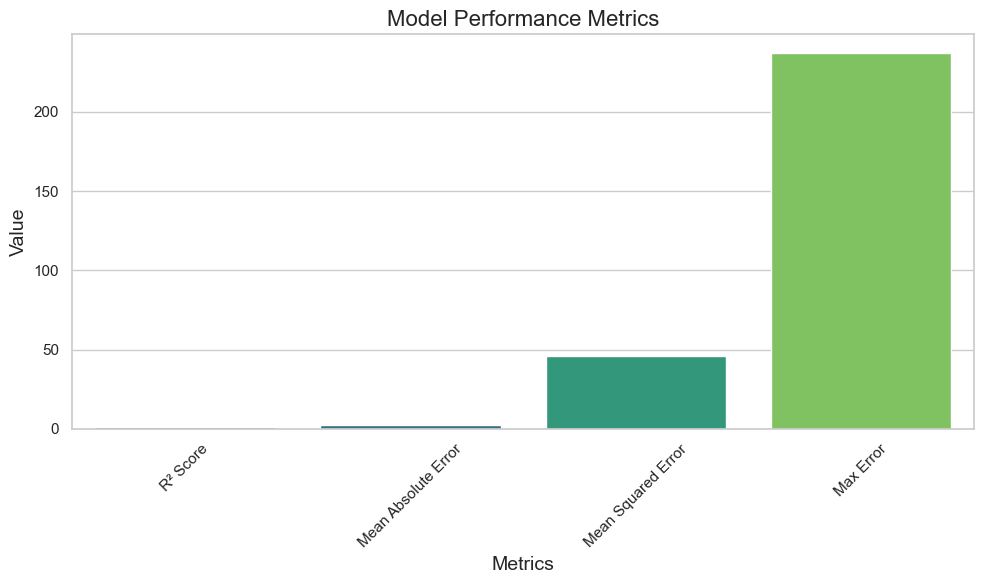

In [197]:
metrics = {
    'R² Score':err_1,
    'Mean Absolute Error':err_2,
    'Mean Squared Error':err_3,
    'Max Error':err_4,
}

metrics_dataframe = pd.DataFrame(list(metrics.items()), columns=['Metrics', 'Value'])
sns.set(style='whitegrid')

plt.figure(figsize=(10,6))
sns.barplot(x="Metrics" , y='Value' , data=metrics_dataframe , palette='viridis')
plt.title('Model Performance Metrics', fontsize=16)
plt.xlabel('Metrics', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


# Sample Prediction

In [177]:


data = {
    'batting_team': ['India'],
    'bowling_team': ['New Zealand'],
    'city': ['Christchurch'],
    'current_score': [50],  
    'balls_left': [120],    
    'wickets_left': [7],    
    'crr': [2.5],           
    'last_five': [15]       
}


input_df = pd.DataFrame(data)


In [190]:
predicted_score = pipeline.predict(input_df)
predicted_score = int(floor(predicted_score[0]))  
print(f'Predicted Total Score: {predicted_score}') # real score was 108 (played between NZ and IND on 01/01/03)

Predicted Total Score: 111


In [201]:
datafr = {
    'batting_team': ['India'],
    'bowling_team': ['Pakistan'],
    'city': ['Manchester'],
    'current_score': [180],
    'balls_left': [120],
    'wickets_left': [8],
    'crr': [6.00],
    'last_five': [45]
}

inp = pd.DataFrame(datafr)
predict = pipeline.predict(inp)
predict = int(floor(predict[0]))
print(f'Predicted Total Score: {predict}') # real score was 336 

Predicted Total Score: 336
